# Installing essential dependencies

In [ ]:
!pip install -q kaggle
# !pip install Pillow
!pip install opencv-python
!pip install scikit-image

# Imports needed
import os
import json
import shutil
import random

# import glob
import warnings
import numpy as np
import cv2

# from PIL import Image
from skimage.feature import hog
from skimage.transform import resize
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc
from google.colab import files
import matplotlib.pyplot as plt
import joblib

# Set the seed for reproducibility
SET_SEED = 12

# Environment configuration
warnings.filterwarnings("ignore")
random.seed(SET_SEED)
np.random.seed(SET_SEED)

print("Setup complete. Environment ready!")

Setup complete. Environment ready!


# Dataset preparation

In [ ]:
DATASET_PATHS = {
    'faces': '/content/faces',
    'non_faces': '/content/non_faces',
    'test_faces': '/content/test_faces',
    'test_non_faces': '/content/test_non_faces'
}

IMG_NUMB = 5000

## Faces dataset

To train our classifier from scratch, we use the [ **Labeled Faces in the Wild (LFW)**](https://www.kaggle.com/datasets/jessicali9530/lfw-dataset) dataset, composed of “in the wild” images of human faces in different poses and lighting.
- **Source:** downloaded from Kaggle.
- **Number of examples:** `IMG_NUMB = 5000` randomly chosen faces, to keep the training balanced without exceeding resource limits.
- **Organization:** images are saved in `DATASET_PATHS['faces']`.  


In [ ]:
files.upload()  # Loading kaggle.json

with open('kaggle.json') as f:
    kaggle_cred = json.load(f)

os.environ['KAGGLE_USERNAME'] = kaggle_cred['username']
os.environ['KAGGLE_KEY'] = kaggle_cred['key']

Saving kaggle.json to kaggle.json


### Download lfw-dataset (faces images)

In [ ]:
!kaggle datasets download -d jessicali9530/lfw-dataset
!unzip /content/lfw-dataset.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0026.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0027.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0028.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0029.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Sil

#### Organize the dataset

In [ ]:
# Create destination folder if it doesn't exist
os.makedirs(DATASET_PATHS['faces'], exist_ok=True)

# Find all .jpg images
all_images = []
for root, dirs, files in os.walk('/content/lfw-deepfunneled/lfw-deepfunneled'):
    for file in files:
        if file.lower().endswith('.jpg'):
            src_path = os.path.join(root, file)
            all_images.append(src_path)

# Select n random images
random.seed(SET_SEED)  # Set a seed for reproducibility
selected_images = random.sample(all_images, min(IMG_NUMB, len(all_images)))

# Move selected images
moved_count = 0
for src_path in selected_images:
    file = os.path.basename(src_path)
    dest_path = os.path.join(DATASET_PATHS['faces'], file)

    try:
      shutil.move(src_path, dest_path)
      moved_count += 1

    except Exception as e:
        print(f"Error while moving {file}: {e}")

print(f"Operation completed. Moved {moved_count} images to {DATASET_PATHS['faces']}")

Operation completed. Moved 5000 images to /content/faces


## Non faces dataset

To train the model to distinguish faces from backgrounds, we use the [**COCO 2017 Train**](https://cocodataset.org/#home) dataset filtered to exclude all images containing people.
- **Source:** Direct download of `train2017.zip` (~18 GB) from COCO 2017.
- **Filtering:** Using the JSON annotation file, we remove all images containing objects of the “person” category (person_id = 1), thus obtaining a set of “negative” scenes without faces.
- **Number of examples:** `IMG_NUMB = 5000` negative images randomly extracted from the filtered set, to balance the training with faces.
- **Save path:** Images are placed in `DATASET_PATHS['non_faces']`.



### Download COCO2017 dataset (non-face images)


In [ ]:
!mkdir -p /content/coco/images
!wget -c http://images.cocodataset.org/zips/train2017.zip -O /content/coco/images/train2017.zip

--2025-05-23 12:03:17--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.9.171, 3.5.30.156, 52.217.193.49, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.9.171|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘/content/coco/images/train2017.zip’

/content/coco/image 100%[===================>]  18.01G  94.7MB/s    in 4m 8s   

2025-05-23 12:07:25 (74.4 MB/s) - ‘/content/coco/images/train2017.zip’ saved [19336861798/19336861798]



In [ ]:
!unzip /content/coco/images/train2017.zip

Output streaming troncato alle ultime 5000 righe.
 extracting: train2017/000000259556.jpg  
 extracting: train2017/000000381931.jpg  
 extracting: train2017/000000569592.jpg  
 extracting: train2017/000000229396.jpg  
 extracting: train2017/000000488990.jpg  
 extracting: train2017/000000348684.jpg  
 extracting: train2017/000000234031.jpg  
 extracting: train2017/000000563584.jpg  
 extracting: train2017/000000276069.jpg  
 extracting: train2017/000000401194.jpg  
 extracting: train2017/000000502089.jpg  
 extracting: train2017/000000192183.jpg  
 extracting: train2017/000000425127.jpg  
 extracting: train2017/000000126766.jpg  
 extracting: train2017/000000324161.jpg  
 extracting: train2017/000000452746.jpg  
 extracting: train2017/000000423782.jpg  
 extracting: train2017/000000546343.jpg  
 extracting: train2017/000000249290.jpg  
 extracting: train2017/000000025529.jpg  
 extracting: train2017/000000316928.jpg  
 extracting: train2017/000000337866.jpg  
 extracting: train2017/000

In [ ]:
!mkdir -p /content/coco/annotations
!wget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O /content/coco/annotations/annotations_trainval2017.zip

--2025-05-23 12:15:35--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.28.250, 52.216.214.41, 52.217.198.89, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.28.250|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘/content/coco/annotations/annotations_trainval2017.zip’

/content/coco/annot 100%[===================>] 241.19M  22.8MB/s    in 7.2s    

2025-05-23 12:15:42 (33.7 MB/s) - ‘/content/coco/annotations/annotations_trainval2017.zip’ saved [252907541/252907541]



In [ ]:
!unzip -q /content/coco/annotations/annotations_trainval2017.zip -d /content/coco/annotations/

#### Organize the dataset

In [ ]:
# Select non-faces images
annotations_path = '/content/coco/annotations/annotations/instances_train2017.json'
source_images_dir = '/content/train2017'
dest_dir = DATASET_PATHS['non_faces']

# Load COCO annotations
with open(annotations_path, 'r') as f:
    coco_data = json.load(f)

# Identify images with people
person_id = 1  # ID categoria 'person' in COCO
images_with_people = set()

# Find all image IDs that contain people
for annotation in coco_data['annotations']:
    if annotation['category_id'] == person_id:
        images_with_people.add(annotation['image_id'])

# List all images of the train set
all_images = {img['id']: img['file_name'] for img in coco_data['images']}

# Filter images without people
non_face_files = [
    all_images[img_id]
    for img_id in all_images
    if img_id not in images_with_people
]

# Select n random images
random.seed(SET_SEED)  # Set the seed for reproducibility
selected_files = random.sample(non_face_files, min(IMG_NUMB, len(non_face_files)))

# Move selected images
os.makedirs(dest_dir, exist_ok=True)
moved_count = 0

for filename in selected_files:
    src_path = os.path.join(source_images_dir, filename)
    dest_path = os.path.join(dest_dir, filename)

    try:
        shutil.move(src_path, dest_path)
        moved_count += 1
    except FileNotFoundError:
        print(f"Attention: {filename} not found in training dataset")

print(f"Operation completed. Moved {moved_count} images in {dest_dir}")

Operation completed. Moved 5000 images in /content/non_faces


# PREPROCESSING

## Loading and normalization

Loads and normalizes images from a specified folder.
Images are converted to grayscale, scaled to the specified size (150*150), and normalized in the range [0,1] to improve model stability.

In [ ]:
def load_and_normalize(folder_path, target_size=(150, 150)):
    """
    Args:
        folder_path (str): Path to the folder containing the images.
        target_size (tuple, optional): Size to resize images to (width, height).
                                       Default: (150, 150).

    Returns:
        numpy.ndarray: Array containing the normalized images.
    """

    images = []  # List to store uploaded images

    # Iterates through all files in the specified folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):  # Filter only files with the .jpg extension
            img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)  # Upload the image in grayscale
            img = cv2.resize(img, target_size)  # Resize the image to the specified dimensions
            images.append(img / 255.0)  # Normalize the image (from [0, 255] to [0, 1])

    return np.array(images, dtype=np.float32)  # Converts the list to a 32-bit float NumPy array

### Loading datasets

In [ ]:
%%time

faces = load_and_normalize(DATASET_PATHS['faces'])
non_faces = load_and_normalize(DATASET_PATHS['non_faces'])

CPU times: user 19.5 s, sys: 7.72 s, total: 27.2 s
Wall time: 41.7 s


In [ ]:
print(faces.shape)
print(non_faces.shape)

(5000, 150, 150)
(5000, 150, 150)


## Augmentation

Performs data augmentation in an optimized way to reduce RAM consumption.

A series of random transformations are applied:
- Rotation
- Scaling
- Translation
- Brightness variation

To avoid running out of memory:
- Images are processed in batches, reducing list growth.
- We use NumPy to improve the efficiency of the operations.


In [ ]:
def balanced_augmentation(images, target_samples=3000, batch_size=10):
    """
    Args:
        images (numpy.ndarray): Array containing normalized grayscale images.
        target_samples (int, optional): Total number of images desired after augmentation. Default: 3000.
        batch_size (int, optional): Number of images processed per batch. Default: 10.

    Returns:
        numpy.ndarray: Array containing the original and augmented images.
    """
    rng = np.random.default_rng(SET_SEED)  # Random generator for reproducibility

    # Number of original images
    num_originals = len(images)

    # List to contain the generated data, but limited to batches
    augmented = []

    while len(augmented) < target_samples:
        batch = []  # Create a temporary batch

        for _ in range(min(batch_size, target_samples - len(augmented))):
            img = images[rng.integers(0, num_originals)]  # Select random image

            # Generate random transformations
            angle = rng.uniform(-25, 25)
            scale = rng.uniform(0.85, 1.15)
            tx, ty = rng.integers(-15, 15, size=2)
            brightness = rng.uniform(0.8, 1.2)

            # Apply rotation and scaling
            M = cv2.getRotationMatrix2D((75, 75), angle, scale)
            transformed = cv2.warpAffine(img, M, (150, 150))

            # Apply translation
            M[:, 2] += [tx, ty]
            transformed = cv2.warpAffine(transformed, M, (150, 150))

            # Change the brightness
            transformed = np.clip(transformed * brightness, 0, 1)

            # Convert to float32 to reduce memory usage
            batch.append(transformed.astype(np.float32))

        # Converts the batch to a NumPy array and joins it to the main list
        augmented.append(np.array(batch, dtype=np.float32))

    # Concatenate all batches into a single final array
    return np.concatenate(augmented, axis=0)[:target_samples]


In [ ]:
%%time

aug_faces = balanced_augmentation(faces, target_samples=IMG_NUMB, batch_size=5)
aug_non_faces = balanced_augmentation(non_faces, target_samples=IMG_NUMB, batch_size=5)

# Final balance
X = np.concatenate((aug_faces, aug_non_faces))
y = np.concatenate((np.ones(len(aug_faces)), np.zeros(len(aug_non_faces))))

CPU times: user 30.2 s, sys: 11.1 s, total: 41.3 s
Wall time: 42.1 s


In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SET_SEED)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(7000, 150, 150)
(3000, 150, 150)


## HOG (Histogram of Oriented Gradients)

HOG features are used to represent images robustly to lighting and orientation variations, improving the model's ability to distinguish faces.

**Parameters**
- `images` (`np.ndarray`): grayscale image of size `(height, width)`.
- `pixels_per_cell` (`Tuple[int, int]`, default `(16, 16)`): pixel size of cells within which the gradient histogram is computed.
- `cells_per_block` (`Tuple[int, int]`, default `(2, 2)`): number of cells per block, to locally normalize the histograms.
- `orientations` (`int`, default `8`): number of directions into which to divide the gradient angles.

**Output**
- `hog_features` (`np.ndarray`): A one-dimensional vector containing the HOG descriptor values ​​for the entire image.

**Design choices**
- Using batches allows you to not load all the features into memory at the same time, which is essential on machines with limited resources.
- All images are resized to 150×150 pixels to ensure consistency and control the final size of the descriptor
- **Orientations = 8** offers a good compromise between angular detail and vector length.
- **Pixels per cell = 16×16** size that captures half-face level patterns while maintaining a manageable vector length.
- **Cells per block = 2×2** local normalization that reduces the impact of lighting and contrast variations.

In [ ]:
def extract_hog_features(images, batch_size=50):
    """
    Extracts HOG (Histogram of Oriented Gradients) descriptors from a set of images, processing them in batches to save memory.

    Args:
        images : List[np.ndarray] Input image list.
        batch_size : int, optional (default=50) Number of images to process at a time.

    Returns:
        np.ndarray (n_samples, n_features) containing for each image the HOG feature vector.
    """
    features = []  # List to store HOG features

    for i in range(0, len(images), batch_size):

        batch = images[i:i + batch_size]  # Extract a batch of images

        batch_resized = [cv2.resize(img, (150, 150)) for img in batch]  # Make sure they are 150x150

        batch_features = [hog(img,
                              orientations=8,
                              pixels_per_cell=(16, 16),
                              cells_per_block=(2, 2),
                              visualize=False) for img in batch_resized]

        features.append(np.array(batch_features))  # Convert the batch to array and add it to the list
    return np.concatenate(features, axis=0)  # Merge all batches into a single array

In [ ]:
# HOG Feature Extraction
%%time

X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

CPU times: user 41.6 s, sys: 111 ms, total: 41.8 s
Wall time: 42.1 s


In [ ]:
print(X_train_hog.shape)
print(X_test_hog.shape)

(7000, 2048)
(3000, 2048)


# Model

Main reasons for using a linear kernel SVC:

- **Computational efficiency**

  - Training a linear SVC is significantly faster than non-linear kernels (RBF), especially with a moderate number of samples (10.000 in our case).
  - Prediction is also fast, which is important for use on devices with limited resources.

- **Excellent performance on HOG features**

  HOG features produce a sufficiently linear representation space: a linear separator already offers high accuracy without complex kernels.

- **Simplicity and interpretability**

  Conceptually simple model, easier to debug and maintain, with less risk of overfitting than more complex kernels.


## Hyperparameter search with Grid Search

In our project we chose **Grid Search** because the number of hyperparameters to explore is limited and manageable (only 4 values ​​for C and only one kernel). This allows us to examine **all possible combinations exhaustively**, ensuring that the optimal configuration is identified without excessive computational costs, which is compatible with the hardware constraints of the project.

In [ ]:
%%time

# Distribution of search parameters
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear']
}

search = GridSearchCV(
    SVC(class_weight='balanced', # <-- To check, IMG_NUMB = 5000
        probability=True,
        random_state=SET_SEED),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=3,
    return_train_score=True
)

search.fit(X_train_hog, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: user 2min 25s, sys: 4.32 s, total: 2min 29s
Wall time: 37min 8s


GridSearchCV(cv=5,
             estimator=SVC(class_weight='balanced', probability=True,
                           random_state=12),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'kernel': ['linear']},
             return_train_score=True, scoring='f1', verbose=3)

### Best parameters


In [ ]:
best_params = search.best_params_
print(f"\nBest parameters: {best_params}")


Best parameters: {'C': 0.1, 'kernel': 'linear'}


## MODEL TRAINING

In [ ]:
%%time

# Final model
model = search.best_estimator_
model.fit(X_train_hog, y_train)

CPU times: user 2min 7s, sys: 403 ms, total: 2min 8s
Wall time: 2min 9s


SVC(C=0.1, class_weight='balanced', kernel='linear', probability=True,
    random_state=12)

## Evaluation


### Accuracy

In [ ]:
y_pred = model.predict(X_test_hog)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, digits=4))

Accuracy: 0.8943
              precision    recall  f1-score   support

         0.0     0.8881    0.9062    0.8970      1524
         1.0     0.9010    0.8821    0.8915      1476

    accuracy                         0.8943      3000
   macro avg     0.8946    0.8941    0.8943      3000
weighted avg     0.8945    0.8943    0.8943      3000



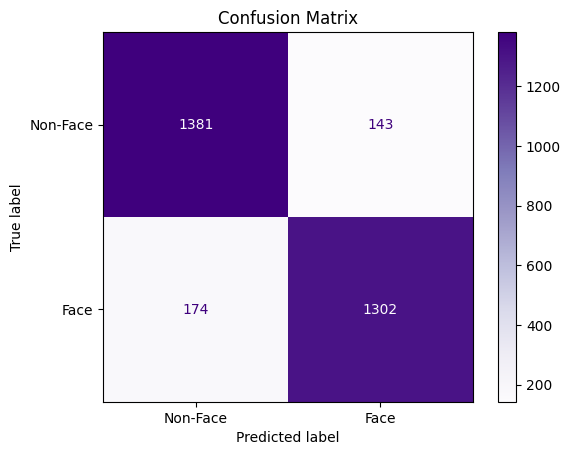

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Face", "Face"])
disp.plot(cmap="Purples")
plt.title("Confusion Matrix")
plt.show()

### Precision-Recall Curve

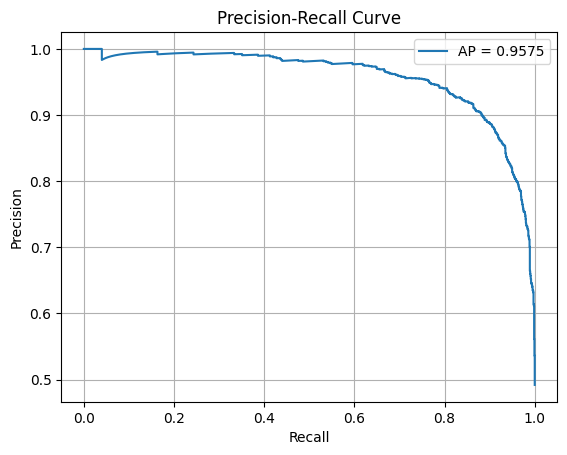

In [ ]:
y_scores = model.decision_function(X_test_hog)
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_prec = average_precision_score(y_test, y_scores)

plt.figure()
plt.plot(recall, precision, label=f"AP = {avg_prec:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

### ROC Curve - AUC

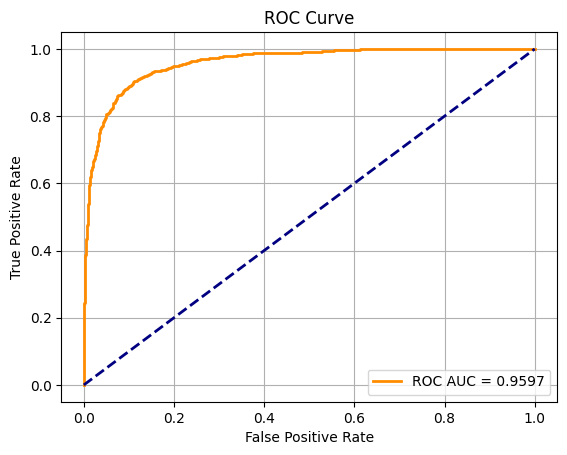

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Model Considerations

- Excellent discriminative ability:

  - The ROC-AUC score of 0.9597 indicates that the model effectively distinguishes between faces and non-faces.

- Excellent average accuracy:

  - The Average Precision (AP) value of 0.9575 shows that the model maintains good precision even when the recall level varies.

- Acceptable balance of errors:

  - Although there are 174 false negatives (faces not detected) and 143 false positives (non-faces incorrectly classified as faces), the main diagonal of the confusion matrix (TN + TP = 2683) is dominant, suggesting a good ability of the model to generalize.

#### Conclusions

The linear kernel SVM model showed excellent overall performance on a binary face detection task. The high AP and ROC-AUC demonstrate that the classifier is robust and reliable, although a more in-depth analysis of the errors can guide future improvements, especially in reducing false negatives.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Saving the model

In [ ]:
model_path = "/content/drive/MyDrive/face_detection_svm.pkl"
joblib.dump(model, model_path)
print(f"Model saved in: {model_path}")

Model saved in: /content/drive/MyDrive/face_detection_svm.pkl


## Loading the saved model

In [ ]:
model_path = "/content/drive/MyDrive/face_detection_svm.pkl"

model = joblib.load(model_path)
print("Model uploaded successfully!")

Model uploaded successfully!


# INFERENCE AND VISUALIZATION

Detect faces in an image using a sliding window and an SVM model based on HOG features.

The `detect_faces()` function splits the image into small windows, extracts HOG features, and uses the SVM model to classify each window as either a "face" or a "non-face". Bounding boxes are returned only for windows with a probability greater than the specified threshold, otherwise an empty list is returned.

In [ ]:
def detect_faces(image_path, model, threshold=0.65):
    """
    Args:
        image_path (str): Path to the image to analyze.
        model (sklearn.svm.SVC): Pre-trained SVM model for face detection.
        threshold (float, optional): Probability threshold for considering a window as a face. Default: 0.65.

    Returns:
        list: List of bounding boxes of detected faces, each represented as (x, y, width, height).
        If the list is empty, it means that no faces were detected.
    """
    # Upload the original image
    original_img = cv2.imread(image_path)

    # Check if the image has been uploaded correctly
    if original_img is None:
        print(f"Errore: impossibile caricare {image_path}")
        return []

    # Converts the image to grayscale for easier analysis
    gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

    # Resize the image to 150x150 for smooth analysis
    processed_img = cv2.resize(gray_img, (150, 150)) / 255.0  # Normalize between 0 and 1

    # Defines the parameters of the sliding window
    scales = [75, 50, 25]  # Different sizes for sliding window
    step = 15  # Window step

    detections = []  # List to save the bounding boxes of the detected faces

    for win_size in scales:  # Try different window sizes
        windows = []  # List of windows to analyze
        positions = []  # List of window positions

        # Scroll the image with a floating window
        for y in range(0, 150 - win_size, step):  # Iterate on the lines
            for x in range(0, 150 - win_size, step):  # Iterate on the columns

                # Extracts a region of the image corresponding to the moving window
                window = processed_img[y:y+win_size, x:x+win_size]
                window_resized = cv2.resize(window, (150, 150))  # We standardize to 150x150
                windows.append(window_resized)
                positions.append((x, y, win_size))  # Save position and size

        # Batch HOG extraction for all collected windows
        if len(windows) > 0:
            features = extract_hog_features(np.array(windows))  # Batch HOG Feature Extraction

            # Prediction of probabilities for all windows
            probabilities = model.predict_proba(features)[:, 1]  # Probability of being a face

            # We check which windows exceed the threshold
            for i, proba in enumerate(probabilities):
                if proba > threshold:
                    x, y, win_size = positions[i]
                    scale_x, scale_y = original_img.shape[1] / 150, original_img.shape[0] / 150
                    detections.append((
                        int(x * scale_x),  # x original
                        int(y * scale_y),  # y original
                        int(win_size * scale_x),  # original width
                        int(win_size * scale_y)   # original height
                    ))

    for (x, y, w, h) in detections:
      cv2.rectangle(original_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return detections, original_img


Saving 000000000036.jpg to 000000000036.jpg
Face detected at: [(192, 128, 160, 213)]


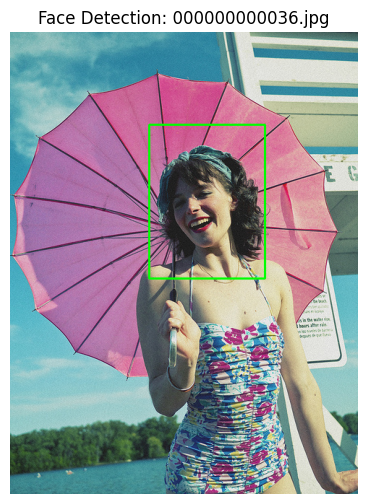

In [ ]:
# Re-import the files module
from google.colab import files

# Loading test images
uploaded = files.upload()
for filename in uploaded.keys():

    # Get both the detections and the image from detect_faces
    detections, img = detect_faces(filename, model, threshold=0.95)

    # Iterate through the detections (the bounding boxes)
    for (x, y, w, h) in detections:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

    if detections:
      print(f"Face detected at: {list(detections)}")
    else:
      temp_list = []
      print(f"No faces detected: {temp_list}")

    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Face Detection: {filename}")
    plt.axis('off')
    plt.show()